In [76]:
import cobra
from cobra.manipulation import remove_genes
from cobra import Model, Reaction, Metabolite
from cobra.flux_analysis import \
    single_gene_deletion, single_reaction_deletion, \
    double_gene_deletion, double_reaction_deletion
import math
import pandas as pd
import sys
import matplotlib.pyplot as plt
# sys.path.append('/home/user/notebook/erol/TB Project/Modules')
# from model_troubleshooting import *
from cobra.flux_analysis import production_envelope
from cobra.flux_analysis import sample
import matplotlib
import numpy as np

This notebook was run using cobra version 0.5.11

In [77]:
print cobra.__version__

0.6.1


### What you need to run this notebook...
1. _iEK1019_ in json format and located in the same folder as this notebook.
2. Griffin Essentiality data

# Load _iEK1020_
Although the model is far from perfect, we believe that _iEK1019_ is a step in the right direction.

In [78]:
model_iEK = cobra.io.load_json_model("iEK1020.json")

In [79]:
print "# of reactions", len(model_iEK.reactions)
print "# of metabolites", len(model_iEK.metabolites)
print "# of genes", len(model_iEK.genes)

# of reactions 1211
# of metabolites 998
# of genes 1020


In [80]:
# for react in model_iEK_before.reactions:
#     if react not in model_iEK.reactions:
#         print react, react.reaction, react.gene_reaction_rule

In [81]:
model_iEK.id

u'iEK1020'

# Check default media condition
- Should be initalized to approximate Middlebrook 7H10 with Acetate as the carbon source as described in _Eoh and Rhee; PNAS 2014_. Although not used in this study, m7H10 with acetate has been used in numerous papers and thus provides a good media intialization.

In [82]:
model_iEK.medium

{u'EX_ac': 10,
 u'EX_btn': 1,
 u'EX_ca2': 1000.0,
 u'EX_cit': 1.0,
 u'EX_cl': 1000.0,
 u'EX_co2': 1000,
 u'EX_cu2': 1000.0,
 u'EX_fe2': 1000.0,
 u'EX_fe3': 1000.0,
 u'EX_glu_L': 1.0,
 u'EX_h': 1000,
 u'EX_h2co3': 1000,
 u'EX_k': 1000,
 u'EX_mg2': 1000.0,
 u'EX_mobd': 1000,
 u'EX_na1': 1000,
 u'EX_nh4': 20,
 u'EX_o2': 20,
 u'EX_pi': 1000,
 u'EX_pydxn': 1,
 u'EX_so4': 1000}

# Check FBA solution
Growth should be about 0.017 mmol/g DW/ hr

In [83]:
model_iEK.optimize().f

0.01692413778583187

# Check Mass Balance
- Exchange reactions are taken out.
- Biomass reactions are taken out.

In [84]:
# print len(cobra.manipulation.validate.check_mass_balance(model_iEK).keys())
mass_bal_metabs, mass_bal_reacts = [], []
for react_id, mass_bal in cobra.manipulation.validate.check_mass_balance(model_iEK).iteritems():
    
    # ------ Don't count exchange reactions and biomass functions -----
    if str(react_id)[:3]!="EX_" and "biomass" not in str(react_id):
        rxn_metabs = [str(x.id) for x in model_iEK.reactions.get_by_id(react_id.id).metabolites]
        mass_bal_metabs.extend(rxn_metabs)
        mass_bal_reacts.append(str(react_id))
        # print str(react_id), mass_bal, react_id.reaction, react_id.gene_reaction_rule

print len(mass_bal_reacts)

34


In [85]:
print mass_bal_reacts  

['FAD_9', 'FAD_10', 'FAD_11', 'FAD_12', 'FAD_13', 'NMO', 'FAD_14', 'FAD_15', 'FAD_16', 'MBTA1', 'FAD_19', 'FAD_20', 'FAD_21', 'FAD_22', 'FAD_24', 'FAD_25', 'FAD_26', 'FAD_27', 'MME', 'FAD_1', 'FAD_2', 'FAD_3', 'MMM2r', 'FAD_4', 'PRCOA1', 'FAD_5', 'VIUB', 'FAD_6', 'FADD3', 'FAD_7', 'PKS121', 'FAD_23', 'FAD_8', 'FADD17']


Most of these are in the two FAD pathways which are independent of the rest of the model. Furthermore, these reactions do contain metabolites that lack both names, IDs, and formulas (I just need to spend a couple hours adding formulas to the metabolites). Not looking at these, only 9 reactions are unbalanced in the model.

In [86]:
# Number of reactions not mass balanced. 4 of these have artifical metabolites (i.e. such as 0.0001 cobalamin) and

# thus cannot be mass balanced - perhaps I should remove said artifical instances.

print len([x for x in mass_bal_reacts if "FAD_" not in x])

9


# Look at Blocked Reactions
Note that it's ok for many reactions to be blocked because the pathway may be incomplete or the ending metabolite has no way to leave the system.

In [87]:
blocked_reacts = cobra.flux_analysis.variability.find_blocked_reactions(model_iEK, 
                                                                        reaction_list=None, 
                                                                        zero_cutoff=1e-09, 
                                                                        open_exchanges=True)
print len(blocked_reacts)

161


In [88]:
blocked_reacts

['2O4EH',
 '2PLS',
 '5DGLCNR',
 'ACPS1',
 'ADCPS2',
 'ADMDCr',
 'AGMT',
 'AH7PK',
 'AHCYSNS',
 'ALATRS',
 'AMAOTr',
 'AOXSr',
 'ARABT',
 'ARGDC',
 'ARGTRS',
 'ASNTRS',
 'ASPTRS',
 'BACCL',
 'BETALDHx',
 'BH7PK',
 'BTNt',
 'CBIAT',
 'CBL2OR',
 'CBLAT',
 'CHOLD',
 'CMLDC',
 'COB2',
 'CPC6R',
 'CPPPGO2',
 'CRNabc',
 'CYANST',
 'CYSK2_I',
 'CYSTRS',
 'Clt',
 'DBTSr',
 'DCPDP',
 'DCYTD',
 'DGC3D',
 'DGK1',
 'DMHDRFS',
 'DURIK1',
 'DURIPP',
 'ERGBSYN',
 'EX_arab_L',
 'EX_atp',
 'EX_btn',
 'EX_ca2',
 'EX_chol',
 'EX_cl',
 'EX_crn',
 'EX_cu2',
 'EX_fe2',
 'EX_glyb',
 'EX_gua',
 'EX_k',
 'EX_malthp',
 'EX_mg2',
 'EX_mn2',
 'EX_mobd',
 'EX_na1',
 'EX_ni2',
 'EX_no',
 'EX_pydxn',
 'EX_tsul',
 'FAH4',
 'FASm3001',
 'FCLPA',
 'FMETTRS',
 'G6PDH',
 'GF4GL_0',
 'GF4GL_1',
 'GLNSP1',
 'GLNSP2',
 'GLNSP3',
 'GLNTRS',
 'GLUTRR',
 'GLYALDDr',
 'GLYBabc',
 'GLYCK',
 'GLYTRS',
 'HISTRS',
 'HOAS',
 'HOPNTAL',
 'ILETRS',
 'LAT',
 'LEUTRS',
 'LPFPLT',
 'LPLIPAL2E180',
 'LPPGS',
 'LYSTRS',
 'MALTHPabc',
 'MANT

# Gene Essentiality
In order to run the following gene essentiality predictions, 

In [89]:
griffin_file = "../../Dataframes/Table_S2.xlsx"
griffin_excel = pd.read_excel(griffin_file,  sheetname='supp table 2',skiprows = 9,keep_default_na=False)

In [90]:
griffin_excel.head()

,Locus,Gene Name,Totals TA's,Total Insertions,Unoccupied Sites,Unoccupied Sites.1,p value,(Sassetti et al 2003)
0,Rv0001,dnaA,32,1,4.365,31,0,essential
1,Rv0002,dnaN,31,0,4.319,31,0,no-data
2,Rv0003,recF,35,11,4.495,7,0.13067,non-essential
3,Rv0004,-,8,2,2.353,6,0.06177,non-essential
4,Rv0005,gyrB,43,3,4.794,40,0,essential


In [91]:
def griffin_essen(model_tb, dic_return):
    model = model_tb.copy()
    
    fal_pos_dic, fal_neg_dic = {}, {}
    true_neg_dic, true_pos_dic = {}, {}
    
    growth_rates = single_gene_deletion(model)
    print "Optimal growth", model.optimize().f
    print model.summary()
    
    orig_growth_thres = 0.25*model.optimize().f
    print "Threshold growth", orig_growth_thres
    
    true_pos, true_neg, fal_pos, fal_neg = 0, 0, 0, 0
    
    # set grif essen threshold -- iSM810 paper uses 0.1 as "confident essential"
    grif_thres = 0.1
    print model.reactions.get_by_id("Kt3r").reaction
    for index, row in griffin_excel.iterrows():
        gene = str(row["Locus"])
        
        try:
            growth = growth_rates.loc[gene, "flux"]
            
            # True negative - predicts that it grows (not essential) and is correct.
            if float(row["p value"]) > grif_thres and growth > orig_growth_thres:
                    true_neg = true_neg + 1
                    true_neg_dic.update({gene: [growth, float(row["p value"])]})
                    
            # False negative - predicts that it grows (not essential) when it actually essential
            if float(row["p value"]) < grif_thres and growth > orig_growth_thres:
                    fal_neg = fal_neg + 1
                    fal_neg_dic.update({gene: [growth, float(row["p value"])]})
                    
            if float(row["p value"]) < grif_thres and growth < orig_growth_thres:
                    true_pos = true_pos + 1
                    true_pos_dic.update({gene: [growth, float(row["p value"])]})
                    
            if float(row["p value"]) > grif_thres and growth < orig_growth_thres:
                    fal_pos = fal_pos + 1
                    fal_pos_dic.update({gene: [growth, float(row["p value"])]})
                    
        except:
            pass            
            
    # ---Analyze and Print results ---
    print "TP - TN - FP - FN"
    print true_pos, true_neg, fal_pos, fal_neg
    
    # percent of correct predictions
    perc_correct = (true_pos+true_neg)/(true_pos+true_neg+fal_pos+float(fal_neg))
    print "percent correct: ", perc_correct
    
    # mcc calculation
    MCC_root = math.sqrt((true_pos + fal_pos)*(true_pos + fal_neg)*(true_neg + fal_pos)*(true_neg + fal_neg))
    MCC = (true_pos*true_neg - fal_pos*fal_neg)/MCC_root
    print "Matthew Correlation Coefficient", MCC
    if dic_return == "Yes":
        return fal_neg_dic, fal_pos_dic
    elif dic_return == "Yes both":
        return fal_neg_dic, fal_pos_dic, true_neg_dic, true_pos_dic

Change media

In [92]:
griffin_media = {
    "EX_h": 1000, # hydrogen
    "EX_h2o": 1000, # water
    "EX_o2": 20.0, # oxygen
    "EX_asn_L": 1.0, # asparagine
    "EX_nh4": 10.0, # ammonium
    "EX_cit":5.0, # citrate
    "EX_etoh": 5.0, # ethanol
    "EX_ca2": 1000.0, # calcium for CaCl2
    "EX_cl": 1000.0, # chloride for CaCl2
    "EX_mg2": 1000.0, # mg for MgSO4
    "EX_so4": 1000, # so4 for MgSO4
    "EX_fe3":5.0, # fe3 for ferric
    "EX_glyc":5.0, # glycerol
    "EX_pi":1.0, # phosphate
    "EX_chsterol":5.0, # cholesterol
}

In [93]:
model_iEK.medium = griffin_media

Calculate the Matthews correlation coefficient. It should be around **0.532**.

In [94]:
FN_dic, FP_dic, TN_dic, TP_dic = griffin_essen(model_iEK, "Yes both")

Optimal growth 0.322258257973
IN FLUXES             OUT FLUXES         OBJECTIVES
--------------------  -----------------  --------------
o2_e        18.6      h2o_e   31.2       biomass  0.322
h_e         14.6      co2_e   13.6
cit_e        5        succ_e   7.8
etoh_e       5        hia_e    0.0315
glyc_e       5        4hba_e   0.000258
asn__L_e     1
pi_e         0.436
nh4_e        0.261
so4_e        0.0438
chsterol_e   0.0315
fe3_e        0.00229
None
Threshold growth 0.0805645644932
k_c <-- k_e
TP - TN - FP - FN
245 539 54 176
percent correct:  0.773175542406
Matthew Correlation Coefficient 0.530468805079


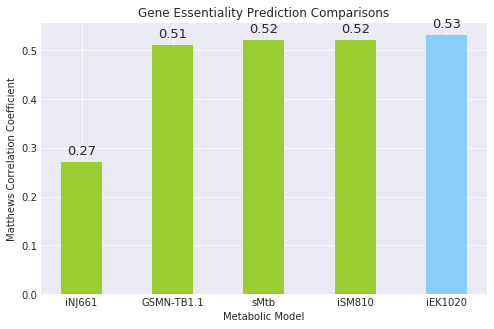

In [95]:
%matplotlib inline
matplotlib.style.use('seaborn-darkgrid')

mcc = (0.27, 0.51, 0.52, 0.52, 0.53)
N = 5
ind = np.arange(N)  # the x locations for the groups
width = .45
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['yellowgreen','yellowgreen','yellowgreen','yellowgreen','lightskyblue']
rects1 = ax.bar(ind, mcc, width,align='center', color=colors)

# ---- Add some text for labels, title and axes ticks
ax.set_ylabel('Matthews Correlation Coefficient')
ax.set_xlabel('Metabolic Model')
ax.set_title('Gene Essentiality Prediction Comparisons')
ax.set_xticks(ind)
ax.set_xticklabels(('iNJ661', 'GSMN-TB1.1', 'sMtb', 'iSM810', 'iEK1020'))
# ----- Add values on top of barchart
rects = ax.patches
# Now make some labels
# labels = ["label%d" % i for i in xrange(len(rects))]
labels = mcc
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+0.01, label, ha='center', 
            va='bottom',fontsize=13)

fig.savefig("../../Figures/gene_essentiality_comparisons.svg", bbox_inches='tight')

# _in Vitro_ vs _in Vivo_ simulations
- Two media conditions contrasting petri dish and host environment...  
    - inVitro_drugTesting
    - inVivo_conditions

### Definte _in vitro_ and _in vivo_ media conditions

In [96]:
inVitro_drugTesting = {
 'EX_asn_L': 1,
 'EX_ca2': 1000.0,
 'EX_cit': 1.0,
 'EX_cl': 1000.0,
 'EX_etoh': 1,
 'EX_fe3': 5.0,
 'EX_glyc': 1.0,
 'EX_h': 1000,
 'EX_mg2': 1000.0,
 'EX_mobd': 1000,
 'EX_nh4': 20.0,
 'EX_o2': 20.0,
 'EX_pi': 1000,
 'EX_so4': 1000,
}

inVivo_conditions = {
 'EX_ala_L': 1,
 'EX_asn_L': 5,
 'EX_asp_L': 5,
 'EX_urea': .1, 
 'EX_glu_L': 1,
 'EX_gln_L': 1, 
 'EX_ca2': 1000,
 'EX_cl': 1000,
 'EX_co2': 1000,
 'EX_cobalt2': 1000,
 'EX_cu2': 1000,
 'EX_fe3': 5,
 'EX_h': 1000,
 'EX_hdca': 10,
 'EX_k': 1000,
 'EX_mg2': 1000,
 'EX_mobd': 1000,
 'EX_na1': 1000,
 'EX_no3': 1.5,
 'EX_o2': .5, # - hypoxia
 'EX_pi': 1000,
 'EX_ppa': 20,
 'EX_so4': 1000,
 'EX_ocdca': 10,
 'EX_ttdca': 10,
 "EX_nodcoa": 10,
 'EX_chsterol': 10,
 "EX_octscoa": 10,

}

### Compute FVA for _in vitro_ model

Stated as 0.059 in the paper.

In [97]:
model_iEK.medium = inVitro_drugTesting
solution = model_iEK.optimize()
pfba_norm_solution = cobra.flux_analysis.pfba(model_iEK)

print "Optimal growth: ", pfba_norm_solution.fluxes["biomass"]
print "ICL FBA flux:", solution.fluxes["ICL"]
print "ICL pFBA flux:", pfba_norm_solution.fluxes["ICL"]
print "Total model flux:", pfba_norm_solution.fluxes.sum()

fva_norm = cobra.flux_analysis.flux_variability_analysis(model_iEK,
                                                        fraction_of_optimum=.95, 
                                                        solver=None)
fva_norm = pd.DataFrame.from_dict(fva_norm).T.round(5)
print "----"
print model_iEK.summary()
print "----"
print "Max ICL flux variability:", fva_norm["ICL"]["maximum"]

Optimal growth:  0.0593715098976
ICL FBA flux: 0.0
ICL pFBA flux: 0.0
Total model flux: 45.7341567095
----
IN FLUXES          OUT FLUXES        OBJECTIVES
-----------------  ----------------  ---------------
o2_e      5.07     h2co3_e  4.43     biomass  0.0564
h_e       4.56     succ_e   2
asn__L_e  1        h2o_e    1.87
cit_e     1        nh4_e    1.6
etoh_e    1        4hba_e   4.5e-05
glyc_e    1
pi_e      0.0764
so4_e     0.00767
fe3_e     0.0004
None
----
Max ICL flux variability: 0.1959


### Compute FVA for _in vivo_ model

The hypoxic growth condition is slower with a value of 0.039

In [98]:
model_iEK.medium = inVivo_conditions
solution = model_iEK.optimize()
pfba_hypox_solution = cobra.flux_analysis.pfba(model_iEK)

print "Optimal growth: ", pfba_hypox_solution.fluxes["biomass"]
print "ICL FBA flux:", solution.fluxes["ICL"]
print "ICL pFBA flux:", pfba_hypox_solution.fluxes["ICL"]
print "Total model flux:", pfba_hypox_solution.fluxes.sum()

fva_hypoxia = cobra.flux_analysis.flux_variability_analysis(model_iEK,
                                                            fraction_of_optimum=.95, 
                                                            solver=None)
fva_hypox = pd.DataFrame.from_dict(fva_hypoxia).T.round(5)
print "----"
print model_iEK.summary()
print "----"
print "Max ICL flux variability:", fva_hypox["ICL"]["maximum"]

Optimal growth:  0.0390441361382
ICL FBA flux: 0.029929360645
ICL pFBA flux: 0.029929360645
Total model flux: 17.3705449626
----
IN FLUXES             OUT FLUXES         OBJECTIVES
--------------------  -----------------  ---------------
h_e        12.7       co2_e     7.56     biomass  0.0371
asp__L_e    5         nh4_e     6.13
no3_e       1.5       ala__B_e  4.14
asn__L_e    1.06      succ_e    2.75
ala__L_e    1         val__L_e  0.451
glu__L_e    1         coa_e     0.081
o2_e        0.5       ac_e      0.00446
urea_e      0.1       4hba_e    3e-05
gln__L_e    0.0797
octscoa_e   0.0708
pi_e        0.048
nodcoa_e    0.0109
so4_e       0.00431
fe3_e       0.000263
None
----
Max ICL flux variability: 0.3024


#### Compare model simulations

In [99]:
reacts_of_interest = ['EX_succ', 'EX_ac', 'EX_nh4', 'ICL', '2MCS', 'ICDHy','KGD2', 'ENO', 'PEPCK_re', 'ATPS4r']

for react in reacts_of_interest:
    print react
    print "pFBA:", pfba_norm_solution.fluxes[react] ,pfba_hypox_solution.fluxes[react]
    print "FVA max:", fva_norm[react]["maximum"], fva_hypox[react]["maximum"]
    print "FVA min:", fva_norm[react]["minimum"], fva_hypox[react]["minimum"]
    print "-----"

EX_succ
pFBA: 1.9734071621 2.75967481006
FVA max: 2.07476 5.34676
FVA min: 1.39097 2.12661
-----
EX_ac
pFBA: 3.06703164376e-09 0.00469267567831
FVA max: 0.24255 0.19729
FVA min: 0.0 0.0
-----
EX_nh4
pFBA: 1.58347412574 5.7046432925
FVA max: 1.6043 8.55932
FVA min: 1.27904 4.91902
-----
ICL
pFBA: 0.0 0.029929360645
FVA max: 0.1959 0.3024
FVA min: 0.0 0.0
-----
2MCS
pFBA: 0.0 0.0
FVA max: 0.07923 0.19617
FVA min: 0.0 0.0
-----
ICDHy
pFBA: 1.98461721563 0.794742945001
FVA max: 2.02343 2.09008
FVA min: 1.3164 0.47001
-----
KGD2
pFBA: -1.95611556607 -1.85988277615
FVA max: -1.25949 -1.53189
FVA min: -1.99636 -3.15196
-----
ENO
pFBA: 0.651929080837 -0.196150178411
FVA max: 0.71368 -0.18634
FVA min: -0.48628 -0.35336
-----
PEPCK_re
pFBA: -0.0557797292758 0.207607133542
FVA max: 0.64592 4.91173
FVA min: -1.03903 0.03444
-----
ATPS4r
pFBA: 6.61484813403 4.59009968068
FVA max: 8.75653 5.07951
FVA min: 6.29049 3.13302
-----


### Compare sampled spaces

_in vitro_ conditions

In [111]:
model_iEK.medium = inVitro_drugTesting
pfba_solution = cobra.flux_analysis.pfba(model_iEK)
opt_value = pfba_solution["biomass"]

# -- constrain solution space to 0.95 of optimum --
with model_iEK:
    print model_iEK.reactions.get_by_id("biomass").lower_bound
    model_iEK.reactions.get_by_id("biomass").lower_bound = opt_value*.95
    print model_iEK.reactions.get_by_id("biomass").lower_bound
    %time inVitro_samples = sample(model_iEK, 10000, processes=4)
    print inVitro_samples.head()

0
0.0564029344167
CPU times: user 45.8 s, sys: 1min 6s, total: 1min 52s
Wall time: 1min 7s
   2AGPEAT160  2AGPEAT180  5DGLCNR   AACPS10   AACPS11    AACPS3      ABTA  \
0    0.000003    0.000006      0.0  0.003467  0.000465  0.001119  0.000006   
1    0.000004    0.000009      0.0  0.003474  0.000465  0.001163  0.000007   
2    0.000128    0.000006      0.0  0.003468  0.000534  0.001101  0.000005   
3    0.000128    0.000006      0.0  0.003467  0.000534  0.001490  0.000004   
4    0.000128    0.000006      0.0  0.003467  0.000534  0.002004  0.000004   

    ACACT1r    ACALDi  ACBIPGT     ...        ACYP_2   GTPDPDP   PPGPPDP  \
0  0.000181  1.016693      0.0     ...      0.000006  0.000002  0.000002   
1  0.000181  1.028069      0.0     ...      0.000007  0.000002  0.000002   
2  0.000181  1.023392      0.0     ...      0.000027  0.000002  0.000002   
3  0.000181  1.022842      0.0     ...      0.001156  0.000001  0.000001   
4  0.000181  1.030049      0.0     ...      0.001157  0.0000

_in vivo_ conditions

In [112]:
model_iEK.medium = inVivo_conditions
pfba_solution = cobra.flux_analysis.pfba(model_iEK)
opt_value = pfba_solution["biomass"]

# -- constrain solution space to 0.95 of optimum --
with model_iEK:
    print model_iEK.reactions.get_by_id("biomass").lower_bound
    model_iEK.reactions.get_by_id("biomass").lower_bound = opt_value*.95
    print model_iEK.reactions.get_by_id("biomass").lower_bound
    %time inVivo_samples = sample(model_iEK, 10000, processes=4)
    print inVivo_samples.head()

0
0.0370919293313
CPU times: user 41 s, sys: 59.8 s, total: 1min 40s
Wall time: 1min 9s
   2AGPEAT160  2AGPEAT180  5DGLCNR  AACPS10   AACPS11    AACPS3      ABTA  \
0    0.000002    0.000005      0.0  0.00228  0.000300  0.000702  0.000005   
1    0.000002    0.000005      0.0  0.00228  0.000300  0.000701  0.000005   
2    0.000002    0.000005      0.0  0.00228  0.000301  0.000705  0.000005   
3    0.000002    0.000005      0.0  0.00228  0.000298  0.000726  0.000005   
4    0.000002    0.000005      0.0  0.00228  0.000302  0.000723  0.000011   

    ACACT1r    ACALDi       ACBIPGT     ...        ACYP_2   GTPDPDP   PPGPPDP  \
0  0.000119  0.000007  1.274845e-04     ...      0.000005  0.000002  0.000002   
1  0.000119  0.000007  1.272570e-04     ...      0.000005  0.000002  0.000002   
2  0.000119  0.000007  1.216423e-04     ...      0.000005  0.000002  0.000002   
3  0.000119  0.000007  9.483731e-08     ...      0.000035  0.000002  0.000002   
4  0.000119  0.000007  5.422707e-07     ... 

## Comparison Plots

In [113]:
%matplotlib inline
plt.style.use('seaborn-white')

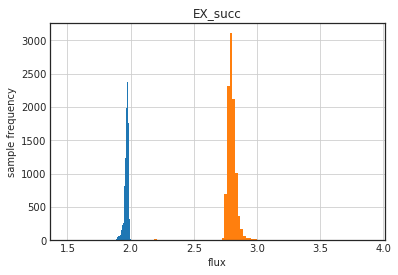

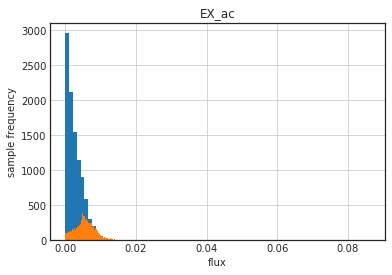

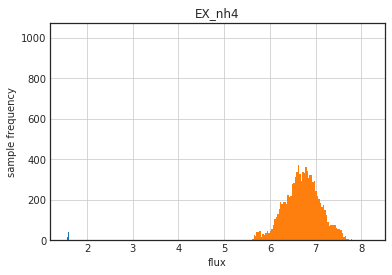

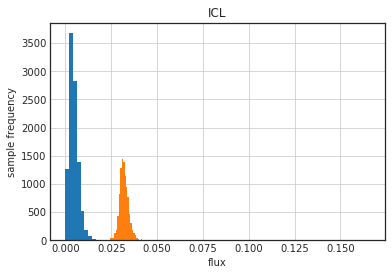

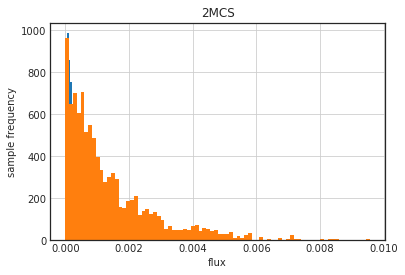

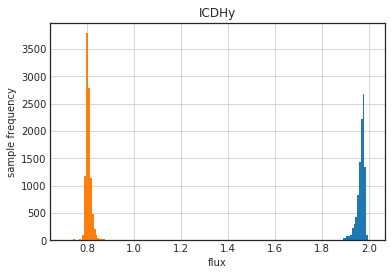

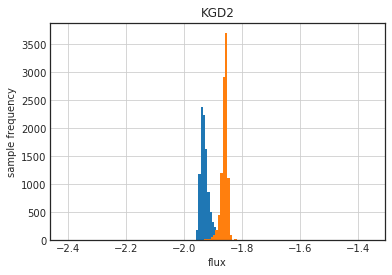

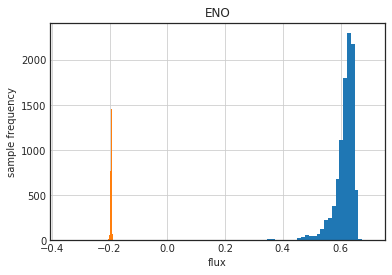

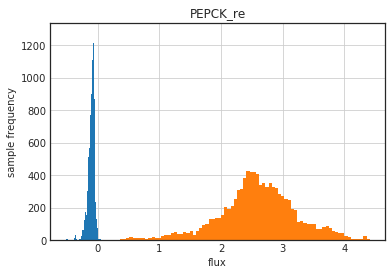

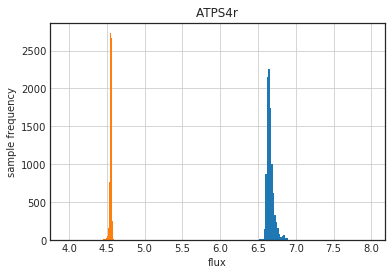

In [114]:
for react in reacts_of_interest:
    inVitro_samples[react].hist(bins=80)
    inVivo_samples[react].hist(bins=80)
    plt.title(react)
    plt.ylabel("sample frequency")
    plt.xlabel("flux")
    plt.show()

## Box plots

In [115]:
def plot_box_plot(samples1, samples2, name1, name2, rxn, title):
    box_1 = samples1[rxn].copy()
    box_1.name = name1
    box_2 = samples2[rxn].copy()
    box_2.name = name2
    box_df = pd.concat([box_1, box_2], axis=1)
    color = dict(boxes='k', whiskers='k', medians='r', caps='Gray')
    box_df.plot.box(sym='', title=title, color=color)
    plt.ylabel("Flux")
    # save_fig_name = rxn+"_sampling_boxplot.svg"
    # plt.savefig(save_fig_name)

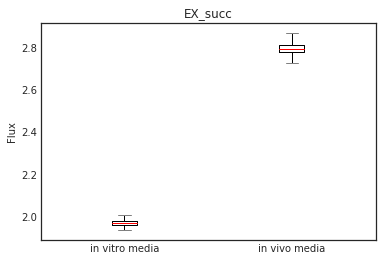

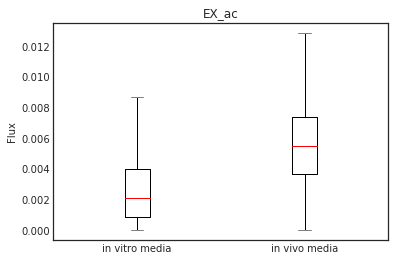

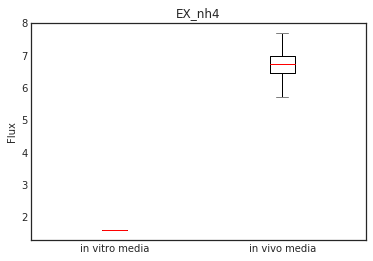

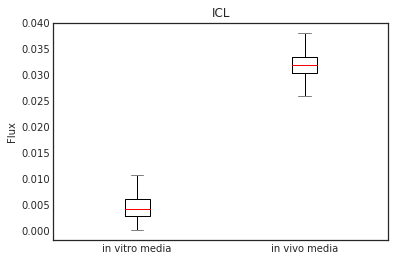

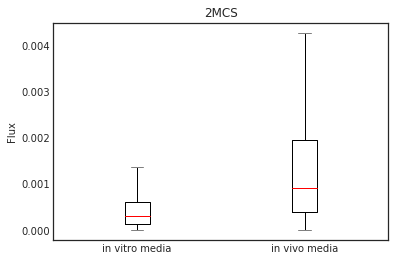

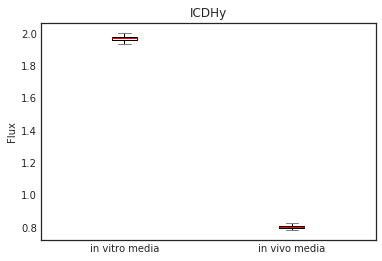

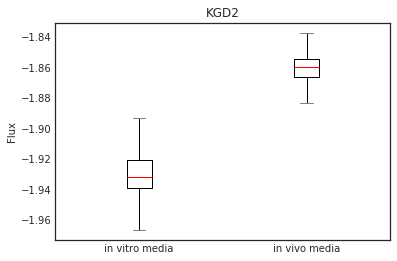

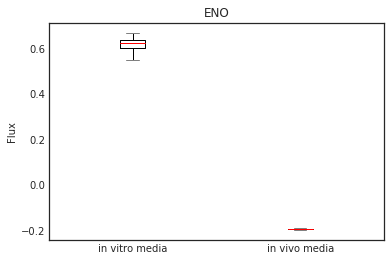

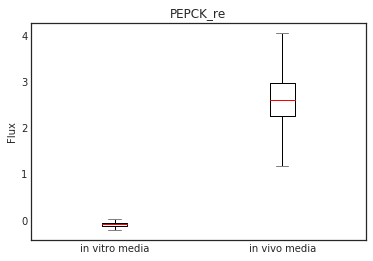

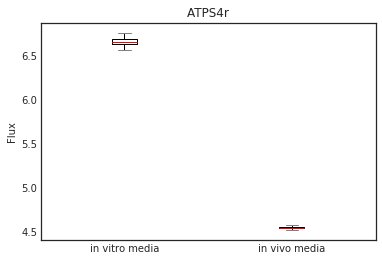

In [116]:
for react in reacts_of_interest:
    plot_box_plot(inVitro_samples, inVivo_samples, 
               "in vitro media", "in vivo media", 
               react, 
               react)

# Output to excel sheet.

Prepare _iEK1020_ reaction and metabolite sheets. The gene sheet with references was manually generated.

In [117]:
model_iEK = cobra.io.load_json_model("iEK1020.json")
print model_iEK.medium
react_dict = []
for react in model_iEK.reactions:
    react_dict.append({'Reaction ID': str(react.id), 
                       'Reaction Name': str(react.name), 
                       'Subsystem': str(react.subsystem), 
                       'Reaction Formula': str(react.reaction),
                       'Lower Bound': str(react.lower_bound),
                       'Upper Bound': str(react.upper_bound),
                       'Gene Reaction Rule': str(react.gene_reaction_rule)
                 })
react_df = pd.DataFrame(react_dict)
react_df = react_df[["Reaction ID", 'Reaction Name', 'Subsystem', 'Reaction Formula', 
                     'Lower Bound', 'Upper Bound', 'Gene Reaction Rule' ]]

metab_dict = []
for metab in model_iEK.metabolites:
    metab_dict.append({'Metabolite ID': str(metab.id), 
                       'Metabolite Name': str(metab.name), 
                       'Metabolite Formula': str(metab.formula), 
                 })
metab_df = pd.DataFrame(metab_dict)
metab_df = metab_df[["Metabolite ID", 'Metabolite Name', 'Metabolite Formula']]

{u'EX_k': 1000, u'EX_cu2': 1000.0, u'EX_fe2': 1000.0, u'EX_ca2': 1000.0, u'EX_glu_L': 1.0, u'EX_nh4': 20, u'EX_ac': 10, u'EX_co2': 1000, u'EX_fe3': 1000.0, u'EX_cl': 1000.0, u'EX_h': 1000, u'EX_btn': 1, u'EX_mobd': 1000, u'EX_na1': 1000, u'EX_pi': 1000, u'EX_h2co3': 1000, u'EX_cit': 1.0, u'EX_o2': 20, u'EX_so4': 1000, u'EX_pydxn': 1, u'EX_mg2': 1000.0}


In [118]:
model_iEK.id

u'iEK1020'

Prepare Griffin Essentiality sheet.

In [119]:
gene_essential_dic = []
for gene in model_iEK.genes:
    g = str(gene)
    if g in FN_dic.keys():
        ko_growth_rate = FN_dic[g][0]
        griff_p_val = FN_dic[g][1]
        error_type = "False Negative"
    if g in FP_dic.keys():
        ko_growth_rate = FP_dic[g][0]
        griff_p_val = FP_dic[g][1]
        error_type = "False Positive"
    if g in TN_dic.keys():
        ko_growth_rate = TN_dic[g][0]
        griff_p_val = TN_dic[g][1]
        error_type = "True Negative"
    if g in TP_dic.keys():
        ko_growth_rate = TP_dic[g][0]
        griff_p_val = TP_dic[g][1]
        error_type = "True Positive"
    gene_essential_dic.append({"Gene": g, 
                               "KO Growth Rate": ko_growth_rate, 
                               "Griffin Essentiality P-Value": griff_p_val,
                               "Error Type": error_type
                              })
    
gene_essen_df = pd.DataFrame(gene_essential_dic)
gene_essen_df = gene_essen_df[["Gene", "KO Growth Rate", "Griffin Essentiality P-Value", "Error Type"]]
gene_essen_df.head()

,Gene,KO Growth Rate,Griffin Essentiality P-Value,Error Type
0,Rv1295,-1.461829e-16,0.00001,True Positive
1,Rv2573,1.071122e-14,0.71349,False Positive
2,Rv3815c,-9.302549e-17,0.97648,False Positive
3,Rv3290c,3.222583e-01,0.96172,True Negative
4,Rv2589,3.222583e-01,0.93677,True Negative


Prepare media conditions as JSON files.

In [120]:
media_conditions = [model_iEK.medium, griffin_media, inVitro_drugTesting, inVivo_conditions]
media_df = pd.DataFrame(media_conditions)
media_df = media_df.transpose()
media_df.columns = ["Middlebrook m7H10 (Acetate C-source)", 
                    "Griffin Media (Gene Essentiality)", 
                    "Lowenstein-Jensen Media (Drug-Testing)", 
                    "Physiological Media (in vivo modeling)"]
media_df.head()

,Middlebrook m7H10 (Acetate C-source),Griffin Media (Gene Essentiality),Lowenstein-Jensen Media (Drug-Testing),Physiological Media (in vivo modeling)
EX_ac,10.0,NaN,NaN,NaN
EX_ala_L,NaN,NaN,NaN,1.0
EX_asn_L,NaN,1.0,1.0,5.0
EX_asp_L,NaN,NaN,NaN,5.0
EX_btn,1.0,NaN,NaN,NaN


Write everything to excel file.

In [121]:
writer = pd.ExcelWriter('iEK1020_supplementary.xlsx')
react_df.to_excel(writer, sheet_name='Reactions', index=False)
metab_df.to_excel(writer, sheet_name='Metabolites', index=False)
gene_essen_df.to_excel(writer, sheet_name="Gene Essentiality", index=False)
media_df.to_excel(writer, sheet_name="Media Conditions", index=False)
writer.save()

# The end.